imports
-----------

In [6]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from os.path import join, dirname, abspath
import os
import shutil
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy import stats

%matplotlib inline

In [7]:
from moseq2_viz.model.util import (relabel_by_usage, parse_model_results, compute_syllable_explained_variance)
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import compute_behavioral_statistics
from moseq2_viz.util import read_yaml

upload paths
-------------

In [8]:
progress_filepath = '/n/groups/datta/sherry/dana/male_0219/progress.yaml' # Add the path to your progress.yaml here.
from_CLI = False  # set to True if you are coming from the CLI. Keep False if you used the extraction notebook 
progress_paths = restore_progress_vars(progress_file=progress_filepath, init=from_CLI, overwrite=from_CLI)

model_path = progress_paths['model_path']
config_file = progress_paths['config_file']
index_file = progress_paths['index_file']
crowd_dir = progress_paths['crowd_dir']
syll_info_path = progress_paths['syll_info']
fig_dir = progress_paths['plot_path']

modeling_session_dir = os.path.dirname(model_path)
new_index_path = os.path.join(modeling_session_dir, os.path.basename(index_file))

Updating notebook variables...


In [9]:
model_path

'/n/groups/datta/sherry/dana/male_0219/models/model-non-robust1000-1.p'

data filtering
----------

by 90% explained syll
----------

Number of syllables explaining 90% variance: 73


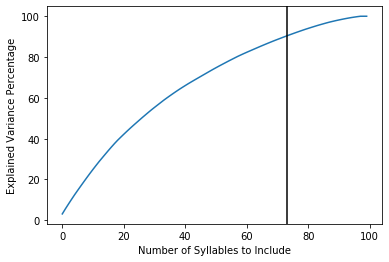

In [10]:
n_explained = 90
# Load the model
model = parse_model_results(model_path)

# Compute the sorted labels
model['labels'] = relabel_by_usage(model['labels'], count='usage')[0]

# Get Maximum number of syllables to include
max_sylls = compute_syllable_explained_variance(model, n_explained)

In [11]:
_, sorted_index = parse_index(progress_paths['index_file'])
# compute session scalar data
scalar_df = scalars_to_dataframe(sorted_index, model_path=progress_paths['model_path'])
print('scalar_df size: ', scalar_df.shape[0], 'rows;', scalar_df.shape[1], 'columns')

# subset scalar df to syll less than max_syll
scalar_df = scalar_df[scalar_df['labels (usage sort)'] < max_sylls]
print('scalar_df size after subsetting: ', scalar_df.shape[0], 'rows;', scalar_df.shape[1], 'columns')

  0%|          | 0/288 [00:00<?, ?it/s]

scalar_df size:  10335476 rows; 31 columns
scalar_df size after subsetting:  8929202 rows; 31 columns


creat mean_df and add labels for mouse, cage, rep
-----------

In [12]:
# compute syllable usage and scalar statistics
count = 'usage'  # can either be usage or frames
syllable_key = 'labels (usage sort)'  # either 'labels (usage sort)', 'labels', or 'labels (frames sort)'
#groupby = ['SubjectName','uuid','group']  # can be any categorical variables
groupby = ['SubjectName','uuid']  # can be any categorical variables
usage_normalization = True  # turn syllable usage into a probability distribution from raw counts

# add back labels
index_data = read_yaml('/n/groups/datta/sherry/dana/male_0219/moseq2-index.yaml')
index_data = pd.DataFrame({'SubjectName':[file['metadata']['SubjectName'] for file in index_data['files']],
                          'group':[file['group'] for file in index_data['files']],
                           'uuid':[file['uuid'] for file in index_data['files']]})

# add mouse names and cages to the df
mean_df = compute_behavioral_statistics(scalar_df, count=count, groupby=groupby, usage_normalization=usage_normalization, syllable_key=syllable_key)
mean_df = mean_df.drop(['SubjectName'], axis=1)
mean_df = pd.merge(mean_df, index_data, left_on = 'uuid', right_on='uuid', how = 'left')

# add mouse names and cages to the df
mean_df['mouse'] = mean_df.SubjectName.str[:5]
mean_df['cage'] = mean_df.SubjectName.str[:2]
mean_df['rep'] = mean_df.SubjectName.str[6:]
mean_df = mean_df.astype({'rep':'int'}) # convert rep to integer
mean_df = mean_df.astype({'cage':'int'}) # convert cage to integer

In [19]:
sorted(mean_df[mean_df.group=='old'].rep.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 19]

In [22]:
# get only the last 7 recording days for each male
mean_df_new = mean_df[(mean_df.group=='new') &(mean_df.rep>10)]
mean_df_new['rep'] = mean_df_new['rep']-10

mean_df_old = mean_df[(mean_df.group=='old') &(mean_df.rep>8)]
mean_df_old['rep'].replace(to_replace=19, value=10, inplace=True) # fixing spelling mistake
mean_df_old['rep'] = mean_df_old['rep']-8

# changing mouse and cage numbers to chronological order
mean_df_old['mouse'] = mean_df_old['mouse'].replace(to_replace=mean_df_old['mouse'].unique(), value=list(range(1,17)))
mean_df_new['mouse'] = mean_df_new['mouse'].replace(to_replace=mean_df_new['mouse'].unique(), value=list(range(17,37)))
mean_df_new['cage'] = mean_df_new['cage'].replace(to_replace=mean_df_new['cage'].unique(), value=list(range(5,10)))

/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/drl21/miniconda/envs/moseq2/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [21]:
sorted(mean_df[mean_df.group=='old'].rep.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 19]

In [99]:
print(mean_df_old.mouse.unique())
print(mean_df_old.cage.unique())
print(mean_df_new.mouse.unique())
print(mean_df_new.cage.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1 2 3 4]
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36]
[5 6 7 8 9]


In [23]:
frames = [mean_df_old, mean_df_new]
mean_df_new = pd.concat(frames)
mean_df = mean_df_new

In [27]:
sorted(mean_df[mean_df.group=='new'].mouse.unique())

[17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

filter syll used above 1%
------------

In [28]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllable']).mean()['usage']
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

include_syll = syll_index_above_threshold(mean_df)
mean_df = mean_df[mean_df.syllable.isin(include_syll)]

In [29]:
len(mean_df.syllable.unique())

41

## quality control for noise syllables

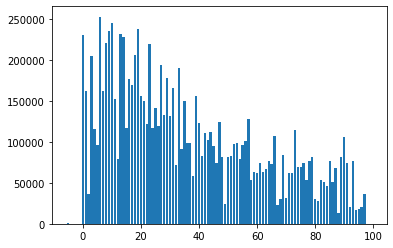

In [30]:
# search of noise syllables
model_results = parse_model_results(model_path,sort_labels_by_usage=True) 
model_labels=model_results['labels']
model_keys=model_results['keys']

#show the syllable length across all sessions. unusually long ones are usually noisy syllables 
data_concatenated=np.hstack(copy.copy(model_labels))
c = Counter(data_concatenated)
plt.bar(c.keys(), c.values())
plt.show()

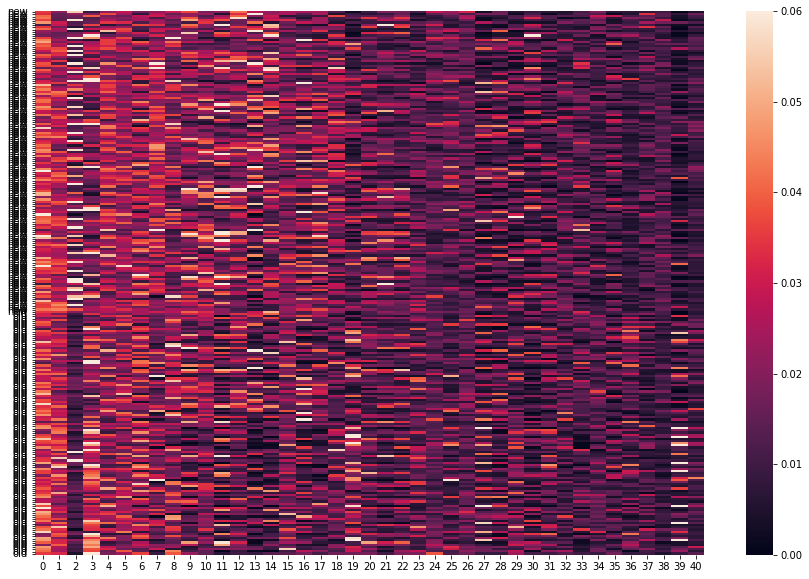

In [31]:
# show syllable loads
# prepare data
data = mean_df.groupby(by = ['group','mouse', 'rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)
data_umap = data.drop(['rep','mouse','group'], axis=1).to_numpy()
data_umap_labels = data['group'].to_numpy()

fig, ax = plt.subplots()
fig.set_size_inches(15,10) 
sns.heatmap(data_umap,vmax=0.06,yticklabels=data_umap_labels)

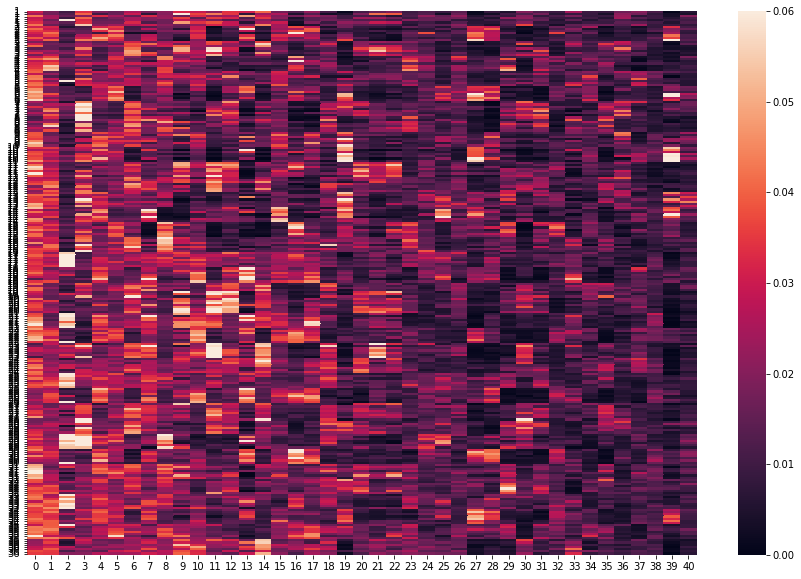

In [33]:
# show syllable loads
# prepare data
data = mean_df.groupby(by = ['mouse', 'rep','syllable']).mean()['usage'].reset_index()
data = pd.pivot_table(data, values='usage', index=['mouse','rep'], columns=['syllable']).reset_index().fillna(0)
data_umap = data.drop(['mouse','rep'], axis=1).to_numpy()
data_umap_labels = data['mouse'].to_numpy()

fig, ax = plt.subplots()
fig.set_size_inches(15,10) 
sns.heatmap(data_umap,vmax=0.06,yticklabels=data_umap_labels)

## make sure scalar df has the same sessions as mean_df

In [34]:
# look before saving

In [84]:
# processing scalar df
uuid_include = mean_df.uuid.unique()
scalar_df = scalar_df[scalar_df.uuid.isin(uuid_include)]

scalar_df['mouse'] = scalar_df.SubjectName.str[:5]
scalar_df['cage'] = scalar_df.SubjectName.str[:2]
scalar_df['rep'] = scalar_df.SubjectName.str[6:]
scalar_df = scalar_df.astype({'rep':'int'}) # convert rep to integer
scalar_df = scalar_df.astype({'cage':'int'}) # convert cage to integer

## save results

In [35]:
#scalar_df.to_csv('/n/groups/datta/Dana/indv/scripts/scalar_df_indv.csv')
mean_df.to_csv('/n/groups/datta/Dana/indv/scripts/mean_df_indv.csv')